In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from typing_extensions import TypedDict

class AgentState(TypedDict):
    query: str
    context: list
    answer: str


In [ ]:
from langchain_community.tools import TavilySearchResults

search_tool = TavilySearchResults(
    max_results = 3, 
    search_depth = "advanced",
    include_answer = True,
    include_raw_content = True, 
    include_images = True 
)

def web_search(state: AgentState):
    query = state['query']
    results = search_tool.invoke(query) 
    print(f'web search results: {results}')
    return {'context': results}



In [4]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

generate_prompt = hub.pull("rlm/rag-prompt")
generate_llm = ChatOpenAI(model="gpt-4o")

def web_generate(state: AgentState):
    query = state['query']
    context = state['context']
    rag_chain = generate_prompt | generate_llm | StrOutputParser()
    response = rag_chain.invoke({'question':query, 'context':context})    
    return {'answer': response}

In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

basic_llm = ChatOpenAI(model="gpt-4o-mini")

def basic_generate(state:AgentState):
    query = state['query']
    basic_llm_chain = basic_llm | StrOutputParser()
    llm_response = basic_llm_chain.invoke(query)
    return {'answer': llm_response}


In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal
from pydantic import BaseModel, Field  


router_system_prompt = """
    You are an expert at routing a user`s quetion to 'vector_store', 'llm', or 'web_search',
    'vector_store' contains information about income tax up to December 2025.
    if you think the question is simple enough use 'llm'
    if you think you need to search the web to answer the question use 'web_search'
"""

router_prompt = ChatPromptTemplate.from_messages([
    ("system", router_system_prompt),
    ('user', '{query}')
])


router_llm = ChatOpenAI(model="gpt-4o-mini")



class Route(BaseModel): # 출력 결과를 해당 데이터 구조로 강제해줌.
    target: Literal['vector_store', 'llm', 'web_search'] = Field( 
        description="The target for the query to answer"
    ) 

structured_router_llm = router_llm.with_structured_output(Route) # LM의 출력이 반드시 Route모델의 형태를 따르도록 강제함.



def router(state:AgentState):
    query = state['query']
    router_chain = router_prompt | structured_router_llm 
    route =  router_chain.invoke({'query': query})
    print(f'route == {route}')
    print(f'route.target == {route.target}')
    
    return route.target


In [7]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

In [ ]:
from income_tax_graph import graph as income_tax_subgraph

graph_builder.add_node('income_tax_agent', income_tax_subgraph) # 다른 그래프를 노드로 추가함.
graph_builder.add_node('web_search', web_search)
graph_builder.add_node('web_generate', web_generate)
graph_builder.add_node('basic_generate', basic_generate)

-----document------
③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.
[전문개정 2009. 12. 31.]
[제목개정 2014. 1. 1.]
제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. 
[개정 2014. 1. 1.]
[전문개정 2009. 12. 31.]
[제목개정 2014. 1. 1.]
제2절 세액의 계산 <개정 2009. 12. 31.>
제1관 세율 <개정 2009. 12. 31.>
제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>
종합소득
┌───────────────┐
│ 과세표준의 6개 구간 │
├───────────────┤
│ 1,400만원 이하        │ 84만원 + (1,400만원을 초과하는 금액의 15%)  │
│ 1,400만원 초과        │ 84만원 + (5,000만원을 초과하는 금액의 24%)  │
│ 8,800만원 이하        │ 624만원 + (5,000만원을 초과하는 금액의 24%)  │
│ 8,800만원 초과        │ 1,536만원 + (8,800만원을 초과하는 금액의 35%)  │
│ 1.5억원 초과          │ 4,046만원 + (1,500만원을 초과하는 금액의

In [9]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START,
    router,
    {
        'vector_store': 'income_tax_agent',
        'llm': 'basic_generate',
        'web_search': 'web_search'
    }
)

graph_builder.add_edge('web_search', 'web_generate')
graph_builder.add_edge('web_generate', END)
graph_builder.add_edge('basic_generate', END)
graph_builder.add_edge('income_tax_agent', END)

In [10]:
graph = graph_builder.compile()

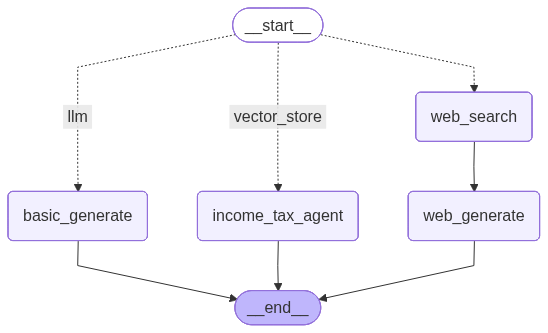

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
initial_state = {'query': '대한민국의 수도는 어디인가요?'}
graph.invoke(initial_state)

router route == target='llm'
route.target == llm


{'query': '대한민국의 수도는 어디인가요?', 'answer': '대한민국의 수도는 서울입니다.'}

In [15]:
initial_state = {'query': '강남역 근처 맛집을 추천해주세요.'}
graph.invoke(initial_state)

router route == target='web_search'
route.target == web_search
web search results: [{'url': 'https://www.youtube.com/watch?v=WVssZrCxG4A', 'content': "# 강남에서만 '16,790끼' 먹은 의사의 Best 5 맛집 소개🍽️\n## 솔직한 의사 생활\n3600 subscribers\n15 likes\n\n### Description\n1414 views\nPosted: 20 Feb 2025\n안녕하세요☺️\n오늘은 36년간 강남에 계셨던 원장님께서\n'강남역 찐맛집'을 추천해 주시는 영상을 준비해 봤는데요 ㅎㅎ\n수많은 음식점이 즐비하는 강남에서 뭘 먹어야 할지 고민이신 분들은 이 영상을 끝까지 시청해 주세요! \n-\nMade with Vrew\n––––––––––––––––––––––––––––––––––––––––––––––––––\n#주름 #흉터 #시술 #쥬브젠 #자가진피재생술 #쥬브젠자가진피재생술 #강남 #맛집 #강남맛집 #추천 #맛집추천 #의사 [...] 우리 어릴 때 먹던 짜장면 집이죠 근데 몇 년 전에 그것도 없어졌어요 그래서 참 섭섭하게 생각합니다 그러면 마지막 한길에 강남역 주변에서 드실 수 있다고 하면 가고 싶은 곳이 있으신가 손님을 배려하거나 그런게 아니고 내가 진짜 입맛 에 맞아서 가고 싶다 마지막 한끼를 강남역에서 먹는다면 나는 번 6번 출고 뒷골목에 가서 안동국시를 먹겠습니다 경상도 말로는 이제 정부지 김치라고 하는 건데 그다음에 이제 깻잎은 간장에 절인 거죠 그게 참 맛있습니다 결국은 뭔가 하면 사람은 누구나 그런가 봐요 아무리 맛있고 비싸고 호화로운 식사보다 어릴 때 먹었던 그런 음식이 제일 인상적인 거 같습니다 그런 것들이 정서적으로 끌리는 거 같아요 저번에 갔던데 그렇지 그죠 그러면 처음 병원을 개업하 때 딱 강남에 오셔서 드셨던 음식이 있으세요 지금도 있습니다 모퉁이 라면 집이라고요 바로 뒤에 있습니다 그분이 

{'query': '강남역 근처 맛집을 추천해주세요.',
 'context': [{'url': 'https://www.youtube.com/watch?v=WVssZrCxG4A',
   'content': "# 강남에서만 '16,790끼' 먹은 의사의 Best 5 맛집 소개🍽️\n## 솔직한 의사 생활\n3600 subscribers\n15 likes\n\n### Description\n1414 views\nPosted: 20 Feb 2025\n안녕하세요☺️\n오늘은 36년간 강남에 계셨던 원장님께서\n'강남역 찐맛집'을 추천해 주시는 영상을 준비해 봤는데요 ㅎㅎ\n수많은 음식점이 즐비하는 강남에서 뭘 먹어야 할지 고민이신 분들은 이 영상을 끝까지 시청해 주세요! \n-\nMade with Vrew\n––––––––––––––––––––––––––––––––––––––––––––––––––\n#주름 #흉터 #시술 #쥬브젠 #자가진피재생술 #쥬브젠자가진피재생술 #강남 #맛집 #강남맛집 #추천 #맛집추천 #의사 [...] 우리 어릴 때 먹던 짜장면 집이죠 근데 몇 년 전에 그것도 없어졌어요 그래서 참 섭섭하게 생각합니다 그러면 마지막 한길에 강남역 주변에서 드실 수 있다고 하면 가고 싶은 곳이 있으신가 손님을 배려하거나 그런게 아니고 내가 진짜 입맛 에 맞아서 가고 싶다 마지막 한끼를 강남역에서 먹는다면 나는 번 6번 출고 뒷골목에 가서 안동국시를 먹겠습니다 경상도 말로는 이제 정부지 김치라고 하는 건데 그다음에 이제 깻잎은 간장에 절인 거죠 그게 참 맛있습니다 결국은 뭔가 하면 사람은 누구나 그런가 봐요 아무리 맛있고 비싸고 호화로운 식사보다 어릴 때 먹었던 그런 음식이 제일 인상적인 거 같습니다 그런 것들이 정서적으로 끌리는 거 같아요 저번에 갔던데 그렇지 그죠 그러면 처음 병원을 개업하 때 딱 강남에 오셔서 드셨던 음식이 있으세요 지금도 있습니다 모퉁이 라면 집이라고요 바로 뒤에 있습니다 그분이 저보다 오래 되셨습니다 저는 90년도 초에 개업을 했는데 그분은 

In [14]:
initial_state = {'query': '연봉 5천만원인 거주자의 소득세는 얼마인가요?'}
graph.invoke(initial_state)

router route == target='vector_store'
route.target == vector_store
query: 연봉 5천만언인 거주자의 소득세는 얼마인가요?
response doc relevance: {'Score': 1, 'Explanation': "To determine the relevance of the FACTS to the QUESTION, we need to examine if the provided information contains any keywords or concepts related to calculating the income tax for a resident with a salary of 50 million won. \n\n1. The FACTS provide information about tax calculations, including comprehensive income tax rates and taxable income rules for residents. These are directly related to the QUESTION, as they give details on how to compute the income tax based on income brackets.\n   - For example, the FACTS mention the tax brackets and applicable rates for comprehensive income, which are essential for calculating the income tax for any given salary, including 50 million won.\n\n2. Although the FACTS cover a broader range of tax-related topics, such as retirement income tax and specific exemptions, the presence of the income brack

{'query': '질문: 연봉 5천만 원인 사람의 소득세는 얼마인가요?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n종합소득\n┌───────────────┐\n│ 과세표준의 6개 구간 │\n├───────────────┤\n│ 1,400만원 이하        │ 84만원 + (1,400만원을 초과하는 금액의 15%)  │\n│ 1,400만원 초과        │ 84만원 + (5,000만원을 초과하는 금액의 24%)  │\n│ 8,800만원 이하        │ 624만원 + (5,000만원을 